This post will explain some of the internals of GAMs: how to estimate the feature functions. First we'll fit some simple splines on some wage data, then we'll fit more complicated splines on some accelerometer data, with a highly non-linear realtionship between in the input and the output.

In [1]:
import pandas as pd
import patsy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

/Users/thomas.kealy/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


GAMs are smooth, semi-parametric models of the form:

$$ y = \sum_{i=0}^{n-1} \beta_i f_i\left(x_i\right) $$

where \\(y\\) is the dependent variable, \\(x_i\\) are the independent variables, \\(\beta\\) are the model coefficients, and \\(f_i\\) are the feature functions.

We build the \\(f_i\\) using a type of function called a spline; splines allow us to automatically model non-linear relationships without having to manually try out many different transformations on each variable. 

First of all, we'll use `patsy` to construct a few spline bases and fit generalised linear models with `statsmodels`. Then, we'll dive into constructing splines ourselves; following Simon Wood's book we'll use penalised regression splines.

Firstly, we'll use `patsy` to create some basic pline models. The data we're using comes from https://vincentarelbundock.github.io/Rdatasets/doc/ISLR/Wage.html. It's plotted below:

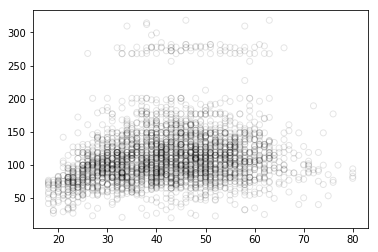

In [2]:
df = pd.read_csv('Wage.csv')
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)

GAMs are essentially linear models, but in a very special (and useful!) basis made of regression splines. We can use the `bs()` function in `patsy` to create such a basis for us:

In [3]:
transformed_x1 = patsy.dmatrix("bs(df.age, knots=(25,40,60), degree=3, include_intercept=False)", {"df.age": df.age}, return_type='dataframe')
fit1 = sm.GLM(df.wage, transformed_x1).fit()

In [4]:
fit1.params

Intercept                                                               60.493714
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]     3.980500
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]    44.630980
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]    62.838788
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]    55.990830
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[4]    50.688098
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[5]    16.606142
dtype: float64

Text(0,0.5,'wage')

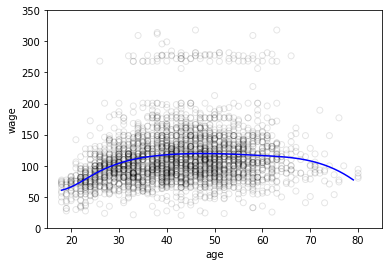

In [5]:
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)
pred = fit1.predict(patsy.dmatrix("bs(age_grid, knots=(25,40,60), include_intercept=False)",
{"age_grid": age_grid}, return_type='dataframe'))
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(age_grid, pred, color='b', label='Specifying three knots')
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')

Here we have prespecified knots at ages 25, 40, and 60. This produces a spline with six basis functions. A cubic spline has 7 degrees of freedom: one for the intercept, and two for each order. We could also have specified knot points at uniform quantiles of the data:

In [6]:
# Specifying 6 degrees of freedom
transformed_x2 = patsy.dmatrix("bs(df.age, df=6, include_intercept=False)",
{"df.age": df.age}, return_type='dataframe')
fit2 = sm.GLM(df.wage, transformed_x2).fit()
fit2.params

Intercept                                       56.313841
bs(df.age, df=6, include_intercept=False)[0]    27.824002
bs(df.age, df=6, include_intercept=False)[1]    54.062546
bs(df.age, df=6, include_intercept=False)[2]    65.828391
bs(df.age, df=6, include_intercept=False)[3]    55.812734
bs(df.age, df=6, include_intercept=False)[4]    72.131473
bs(df.age, df=6, include_intercept=False)[5]    14.750876
dtype: float64

Text(0,0.5,'wage')

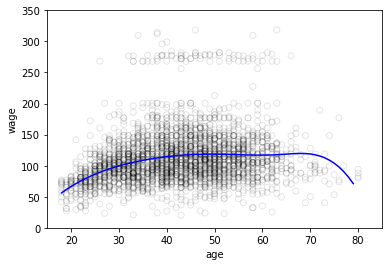

In [7]:
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)
pred = fit2.predict(patsy.dmatrix("bs(age_grid, df=6, include_intercept=False)",
{"age_grid": age_grid}, return_type='dataframe'))
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(age_grid, pred, color='b', label='Specifying three knots')
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')

Finally, we can also fit natural splines with the `cr()` function:

In [8]:
# Specifying 4 degrees of freedom
transformed_x3 = patsy.dmatrix("cr(df.age, df=4)", {"df.age": df.age}, return_type='dataframe')
fit3 = sm.GLM(df.wage, transformed_x3).fit()
fit3.params

Intercept             -6.970341e+13
cr(df.age, df=4)[0]    6.970341e+13
cr(df.age, df=4)[1]    6.970341e+13
cr(df.age, df=4)[2]    6.970341e+13
cr(df.age, df=4)[3]    6.970341e+13
dtype: float64

Text(0,0.5,'wage')

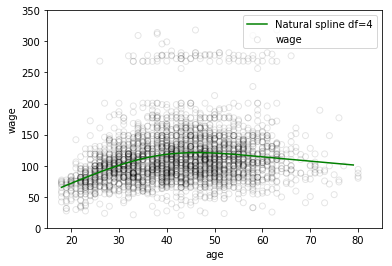

In [9]:
pred = fit3.predict(patsy.dmatrix("cr(age_grid, df=4)", {"age_grid": age_grid}, return_type='dataframe'))
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(age_grid, pred, color='g', label='Natural spline df=4')
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')

Let's see how these fits all stack together:

Text(0,0.5,'wage')

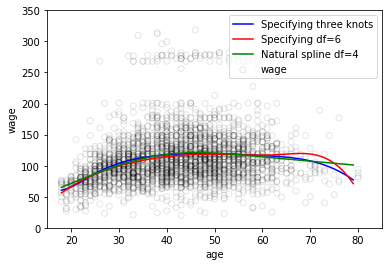

In [10]:
# Generate a sequence of age values spanning the range
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)
# Make some predictions
pred1 = fit1.predict(patsy.dmatrix("bs(age_grid, knots=(25,40,60), include_intercept=False)",
{"age_grid": age_grid}, return_type='dataframe'))
pred2 = fit2.predict(patsy.dmatrix("bs(age_grid, df=6, include_intercept=False)",
{"age_grid": age_grid}, return_type='dataframe'))
pred3 = fit3.predict(patsy.dmatrix("cr(age_grid, df=4)", {"age_grid": age_grid}, return_type='dataframe'))
# Plot the splines and error bands
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(age_grid, pred1, color='b', label='Specifying three knots')
plt.plot(age_grid, pred2, color='r', label='Specifying df=6')
plt.plot(age_grid, pred3, color='g', label='Natural spline df=4')
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')

In [11]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import patsy
import scipy as sp
import seaborn as sns
from statsmodels import api as sm

%matplotlib inline

In [12]:
df = pd.read_csv('mcycle.csv')
df = df.drop('Unnamed: 0', axis=1)

Text(0,0.5,'Acceleration')

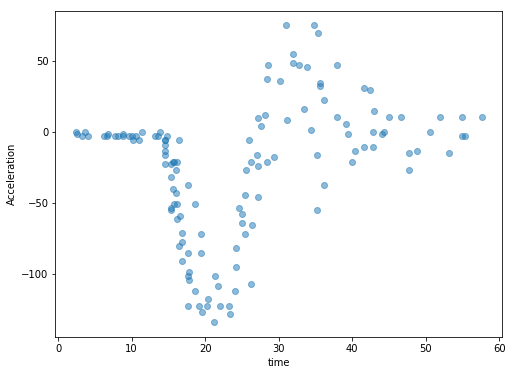

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
blue = sns.color_palette()[0]
ax.scatter(df.times, df.accel, c=blue, alpha=0.5)
ax.set_xlabel('time')
ax.set_ylabel('Acceleration')

As discussed earlier: GAMs are smooth, semi-parametric models of the form:
​
$$ y = \sum_{i=0}^{n-1} \beta_i f_i\left(x_i\right) $$
​
where \\(y\\) is the dependent variable, \\(x_i\\) are the independent variables, \\(\beta\\) are the model coefficients, and \\(f_i\\) are the feature functions.
​
We build the \\(f_i\\) using a type of function called a spline. Since our data is 1D, we can model it as:

$$ y = \beta_0 + f\left( x \right) + \varepsilon $$

We must also choose a basis for \\( f \\):

$$ f \left( x \right) = \beta_1 B_1\left(x\right) + \ldots + \beta_k B_k\left(x\right) $$

We define 

$$ X = \left[1, x_1,  \ldots,  x_k \right] $$

so we can write:

$ y = \beta_0 + f\left( x \right) + \varepsilon = X\beta + \varepsilon $$

We choose to minimise the sum of squares again, this time with a regularisation term:

$$ \frac{1}{2} \lVert y - X\beta \rVert + \lambda \int_0^1 f''\left(x\right)^2 dx $$

You can show (you, not me!) that the second term can always be written:

$$ \int_0^1 f''\left(x\right)^2 dx = \beta^T S \beta $$

where \\( S \\) is a postive (semi)-definiate matrix (i.e. all it's eigenvalues are positive or 0). Therefore our objective function becomes:

$$ \frac{1}{2} \lVert y - X\beta \rVert + \lambda \beta^T S \beta dx $$
 
and we can use the techniques we've developed fitting linear models to fit additive models! We'll start by fitting a univariate spline, then maybe something more complicated.

In [14]:
def R(x, z):
    return ((z - 0.5)**2 - 1 / 12) * ((x - 0.5)**2 - 1 / 12) / 4 - ((np.abs(x - z) - 0.5)**4 - 0.5 * (np.abs(x - z) - 0.5)**2 + 7 / 240) / 24

R = np.frompyfunc(R, 2, 1)

def R_(x):
    return R.outer(x, knots).astype(np.float64)

In [15]:
q = 20

knots = df.times.quantile(np.linspace(0, 1, q))

In [16]:
y, X = patsy.dmatrices('accel ~ times + R_(times)', data=df)

In [17]:
S = np.zeros((q + 2, q + 2))
S[2:, 2:] = R_(knots)

In [18]:
B = np.zeros_like(S)
B[2:, 2:] = np.real_if_close(sp.linalg.sqrtm(S[2:, 2:]), tol=10**8)

/Users/thomas.kealy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [19]:
def fit(y, X, B, lambda_=1.0):
    # build the augmented matrices
    y_ = np.vstack((y, np.zeros((q + 2, 1))))
    X_ = np.vstack((X, np.sqrt(lambda_) * B))
    
    return sm.OLS(y_, X_).fit()

Text(0.5,1,'$\\lambda = 1.0$')

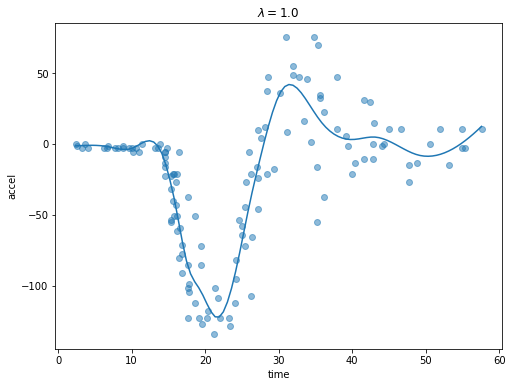

In [30]:
min_time = df.times.min()
max_time = df.times.max()

plot_x = np.linspace(min_time, max_time, 100)
plot_X = patsy.dmatrix('times + R_(times)', {'times': plot_x})

results = fit(y, X, B)

fig, ax = plt.subplots(figsize=(8, 6))
blue = sns.color_palette()[0]
ax.scatter(df.times, df.accel, c=blue, alpha=0.5)
ax.plot(plot_x, results.predict(plot_X))
ax.set_xlabel('time')
ax.set_ylabel('accel')
ax.set_title(r'$\lambda = {}$'.format(1.0))